In [3]:
import numpy as np
import matplotlib.pylab as plt
import scipy.constants as spc
from scipy.integrate import quad
import pandas as pd
from numba import jit

'''
Need to move this to a .py script later on!
'''

'\nNeed to move this to a .py script later on!\n'

In [ ]:
'''
Pressure and Temperatures
'''

pressure = np.loadtxt('pressure_profile_values.csv')

In [4]:
'''
loading datafiles
'''

class spectrum_singleGas(object):

    def __init__(self):
        print('Reading the excel file.')
        self.excel_file = pd.read_excel("Venus Atmosphere.xlsx")

    def getParams(self, text_file):
        f = np.loadtxt(text_file, delimiter=',')
        molecule_id = f[:, 0]
        print('I am molecule ID is '+str(molecule_id[0])+ ' taken from HITRAN database')
        
        isotopologue_id = f[:, 1]
        print('My isotopologue ID is '+str(isotopologue_id[0])+ ' taken from HITRAN database')
        
        v_center = f[:, 2]
        S_0 = f[:, 3]
        delta_air = f[:, 4]
        alphaLorentz_a = f[:, 5]
        alphaDoppler_s = f[:, 6]
        gamma = f[:, 7]
        E_l = f[:, 8]
        
        return molecule_id, v_center, S_0, delta_air, alphaLorentz_a, alphaDoppler_s, gamma, E_l
    
    def setParams(self, molecule_id, v_center, S_0, delta_air, alphaLorentz_a, alphaDoppler_s, gamma, E_l):
        
        self.v_center = v_center
        self.S_0 = S_0
        self.delta_air = delta_air
        self.alphaLorentz_a = alphaLorentz_a
        self.alphaDoppler_s = alphaDoppler_s
        self.gamma = gamma
        self.E_l = E_l
        
        if molecule_id == 5.0:
            molecule = self.excel_file.CO
        if molecule_id == 22.0:
            molecule = self.excel_file.N2
        if molecule_id == 9.0:
            molecule = self.excel_file.SO2
        if molecule_id == 1.0:
            molecule = self.excel_file.H2O
        if molecule_id == 2.0:
            molecule = self.excel_file.CO2
   
        self.q = molecule[0]
        self.m = molecule[1]
        self.coeff1_L = molecule[2] 
        self.coeff2_L = molecule[3]
        self.coeff3_L = molecule[4]
        self.coeff4_L = molecule[5]
        self.coeff1_M = molecule[6] 
        self.coeff2_M = molecule[7]
        self.coeff3_M = molecule[8]
        self.coeff4_M = molecule[9]
        
        self.pressure = 10
        self.temperature = 300
        self.path_length = 5 #[km] this is fixed parameter
        
    def doppler_broadening(self):
        '''
        For pressures less than 0.1 atm, altitudes below 16 km
        '''
        T = self.temperature
        v_center = self.v_center
        m = self.m
        sqrt = np.sqrt(2*spc.k*T/(m*spc.c**2))
        alpha_doppler = v_center*sqrt
        return alpha_doppler 
    
    def lorentz_broadening(self):
        P, T = self.pressure, self.temperature
        P_0, T_0 = 1, 296                         #[atm, K]
        alphaLorentz_a = self.alphaLorentz_a
        alphaLorentz_s = self.alphaDoppler_s
        q = self.q
        gamma = self.gamma 
        pressureRatio = P/P_0
        tempRatio = T_0/T
        alpha_lorentz = ((1-q)*alphaLorentz_a+q*alphaLorentz_s)*pressureRatio*tempRatio**gamma
        return alpha_lorentz
    
    def voigt_profile_substitute(self,v):
        v_c = self.v_center
        if self.pressure > 0.1:
            alpha = self.lorentz_broadening()
            a = ((v - v_c)/alpha)**2
            f = 1/(np.pi*alpha*(1+a))
            return f
        else:
            alpha = self.doppler_broadening()
            sigma = alpha*2/2.355
            a = ((v - v_c)/4*sigma)**2
            f = np.exp(-a)/(sigma*np.sqrt(2*np.pi))
            return f
    
    def line_shape(self, v):
        T = self.temperature
        v_center = self.v_center 
        f = self.voigt_profile_substitute(v)
        tanh = np.tanh(spc.h*spc.c*v/(2*spc.k*T))
        tanh_center = np.tanh(spc.h*spc.c * v_center/(2*spc.k*T))
        g = v * tanh * f/(v_center*tanh_center)
        return g
    
    def total_internal_partition(self, temperature):
        '''
        Valid only for temeratures between 70-1500K
        '''
        T = temperature
        
        if T >= 70 and T <= 500:
            a, b, c, d = self.coeff1_L, self.coeff2_L, self.coeff3_L, self.coeff4_L
            Q = a + b*T + c*T**2 + d*T**3
            return Q
        
        if T > 500 and T <= 1500:
            a, b, c, d = self.coeff1_M, self.coeff2_M, self.coeff3_M, self.coeff4_M
            Q = a + b*T + c*T**2 + d*T**3
            return Q
            
                
    def line_intensity(self):
        T = self.temperature
        v_center = self.v_center
        S_0, T_0 = self.S_0, 296
        Q_T = self.total_internal_partition(T)
        Q_T0 = self.total_internal_partition(296)
        E_l = self.E_l
        exp_lower = np.exp(spc.h*spc.c*E_l/(spc.k*T))
        exp_lower0 = np.exp(spc.h*spc.c*E_l/(spc.k*T_0))
        exp_center = np.exp(spc.h*spc.c*v_center/(spc.k*T))
        exp_center0 = np.exp(spc.h*spc.c*v_center/(spc.k*T))
        S = S_0*Q_T0*exp_lower*exp_center/(Q_T*exp_lower0*exp_center0)
        return S
        
    def transmittance(self, v):
        P = self.pressure
        T = self.temperature
        x = self.path_length
        q = self.q
        g = self.line_shape(v)
        S = self.line_intensity()
        numerator = -q*P*x*S*g
        denominator = spc.Boltzmann * T
        tau = np.exp(numerator/denominator)
        return tau


In [5]:
a = spectrum_singleGas()

Reading the excel file.


In [6]:
molecule_id, v_center, S_0, delta_air, alphaLorentz_a, alphaDoppler_s, gamma, E_l = a.getParams('CO.txt')

I am molecule ID is 5.0 taken from HITRAN database
My isotopologue ID is 1.0 taken from HITRAN database


In [8]:
t_vals = ([])
vals = ([])
i = 0
for center in v_center:
    a.setParams(molecule_id[i], v_center[i], S_0[i], delta_air[i], alphaLorentz_a[i], alphaDoppler_s[i], gamma[i], E_l[i])
    print(center)
    v = np.linspace(center-0.01, center+0.01, 5)
    print(v)
    vals = np.append(vals, v)
    for wavenumber in v:
        tau = a.transmittance(wavenumber)
        t_vals = np.append(t_vals, tau)
    print(i)   
    i = i+1

3.705026
[3.695026 3.700026 3.705026 3.710026 3.715026]
0
3.740024
[3.730024 3.735024 3.740024 3.745024 3.750024]
1
3.775024
[3.765024 3.770024 3.775024 3.780024 3.785024]
2
3.810028
[3.800028 3.805028 3.810028 3.815028 3.820028]
3
3.845033
[3.835033 3.840033 3.845033 3.850033 3.855033]
4
7.409906
[7.399906 7.404906 7.409906 7.414906 7.419906]
5
7.4799
[7.4699 7.4749 7.4799 7.4849 7.4899]
6
7.549901
[7.539901 7.544901 7.549901 7.554901 7.559901]
7
7.619908
[7.609908 7.614908 7.619908 7.624908 7.629908]
8
7.68992
[7.67992 7.68492 7.68992 7.69492 7.69992]
9
11.114491
[11.104491 11.109491 11.114491 11.119491 11.124491]
10
11.219483
[11.209483 11.214483 11.219483 11.224483 11.229483]
11
11.324485
[11.314485 11.319485 11.324485 11.329485 11.334485]
12
11.429495
[11.419495 11.424495 11.429495 11.434495 11.439495]
13
11.534513
[11.524513 11.529513 11.534513 11.539513 11.544513]
14
14.818636
[14.808636 14.813636 14.818636 14.823636 14.828636]
15
14.958626
[14.948626 14.953626 14.958626 14.9636

388
2018.14883
[2018.13883 2018.14383 2018.14883 2018.15383 2018.15883]
389
2020.601738
[2020.591738 2020.596738 2020.601738 2020.606738 2020.611738]
390
2021.561199
[2021.551199 2021.556199 2021.561199 2021.566199 2021.571199]
391
2022.914455
[2022.904455 2022.909455 2022.914455 2022.919455 2022.924455]
392
2025.144711
[2025.134711 2025.139711 2025.144711 2025.149711 2025.154711]
393
2025.876269
[2025.866269 2025.871269 2025.876269 2025.881269 2025.886269]
394
2027.649176
[2027.639176 2027.644176 2027.649176 2027.654176 2027.659176]
395
2029.655904
[2029.645904 2029.650904 2029.655904 2029.660904 2029.665904]
396
2030.158686
[2030.148686 2030.153686 2030.158686 2030.163686 2030.168686]
397
2032.352848
[2032.342848 2032.347848 2032.352848 2032.357848 2032.362848]
398
2034.135174
[2034.125174 2034.130174 2034.135174 2034.140174 2034.145174]
399
2034.408303
[2034.398303 2034.403303 2034.408303 2034.413303 2034.418303]
400
2037.025324
[2037.015324 2037.020324 2037.025324 2037.030324 2037.

[4178.854116 4178.859116 4178.864116 4178.869116 4178.874116]
704
4179.035895
[4179.025895 4179.030895 4179.035895 4179.040895 4179.045895]
705
4180.282526
[4180.272526 4180.277526 4180.282526 4180.287526 4180.292526]
706
4182.075043
[4182.065043 4182.070043 4182.075043 4182.080043 4182.085043]
707
4183.262861
[4183.252861 4183.257861 4183.262861 4183.267861 4183.272861]
708
4185.214797
[4185.204797 4185.209797 4185.214797 4185.219797 4185.224797]
709
4185.29524
[4185.28524 4185.29024 4185.29524 4185.30024 4185.30524]
710
4187.420705
[4187.410705 4187.415705 4187.420705 4187.425705 4187.430705]
711
4188.283232
[4188.273232 4188.278232 4188.283232 4188.288232 4188.293232]
712
4190.240441
[4190.230441 4190.235441 4190.240441 4190.245441 4190.250441]
713
4191.280199
[4191.270199 4191.275199 4191.280199 4191.285199 4191.290199]
714
4191.509279
[4191.499279 4191.504279 4191.509279 4191.514279 4191.519279]
715
4194.205553
[4194.195553 4194.200553 4194.205553 4194.210553 4194.215553]
716
4195

[6411.409918 6411.414918 6411.419918 6411.424918 6411.429918]
1017
6412.055352
[6412.045352 6412.050352 6412.055352 6412.060352 6412.065352]
1018
6412.556836
[6412.546836 6412.551836 6412.556836 6412.561836 6412.566836]
1019
6413.122503
[6413.112503 6413.117503 6413.122503 6413.127503 6413.132503]
1020
6413.582161
[6413.572161 6413.577161 6413.582161 6413.587161 6413.592161]
1021
6414.080824
[6414.070824 6414.075824 6414.080824 6414.085824 6414.090824]
1022
6414.496039
[6414.486039 6414.491039 6414.496039 6414.501039 6414.506039]
1023
6414.930182
[6414.920182 6414.925182 6414.930182 6414.935182 6414.940182]
1024
6415.298617
[6415.288617 6415.293617 6415.298617 6415.303617 6415.308617]
1025
6415.670438
[6415.660438 6415.665438 6415.670438 6415.675438 6415.680438]
1026
6415.990163
[6415.980163 6415.985163 6415.990163 6415.995163 6416.000163]
1027
6416.30144
[6416.29144 6416.29644 6416.30144 6416.30644 6416.31144]
1028
6416.570446
[6416.560446 6416.565446 6416.570446 6416.575446 6416.5804

1311
14411.573983
[14411.563983 14411.568983 14411.573983 14411.578983 14411.583983]
1312
14417.129746
[14417.119746 14417.124746 14417.129746 14417.134746 14417.139746]
1313
14422.441559
[14422.431559 14422.436559 14422.441559 14422.446559 14422.451559]
1314
14427.509275
[14427.499275 14427.504275 14427.509275 14427.514275 14427.519275]
1315
14432.332748
[14432.322748 14432.327748 14432.332748 14432.337748 14432.342748]
1316
14436.911831
[14436.901831 14436.906831 14436.911831 14436.916831 14436.921831]
1317
14441.246377
[14441.236377 14441.241377 14441.246377 14441.251377 14441.256377]
1318
14445.336241
[14445.326241 14445.331241 14445.336241 14445.341241 14445.346241]
1319
14452.781331
[14452.771331 14452.776331 14452.781331 14452.786331 14452.791331]
1320
14456.136263
[14456.126263 14456.131263 14456.136263 14456.141263 14456.146263]
1321
14459.245925
[14459.235925 14459.240925 14459.245925 14459.250925 14459.255925]
1322
14462.110168
[14462.100168 14462.105168 14462.110168 14462.1

<IPython.core.display.Javascript object>


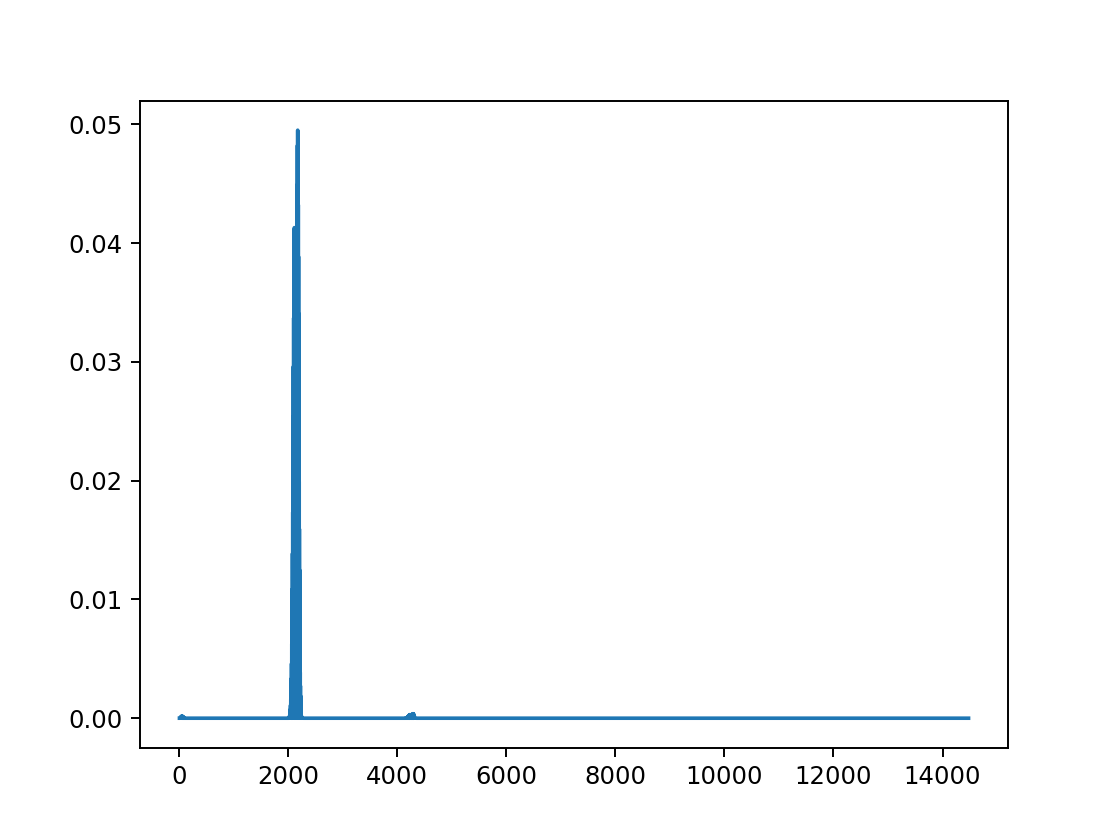

In [11]:
%matplotlib notebook
plt.plot(vals, np.log(1/t_vals))

In [23]:
a = spectrum_singleGas()

Reading the excel file.


In [28]:
a.setParams('N2.txt')

I am molecule ID 22.0 from HITRAN database
My isotopologue ID 1.0 from HITRAN database


In [17]:
v_center, S_0, delta_ait, alphaLorentz_a, alphaDoppler_s, gamma, E_l = get_params('CO.txt')

I am molecule ID 5.0 from HITRAN database
My isotopologue ID 1.0 from HITRAN database, that means I am the most abundant topologue


In [ ]:
'''
Pressure profile numbers
'''
0.03114759459223761, 99.88052581859645
0.04262541256340627, 98.93404132848241
0.07396330468192495, 96.72792770958246
0.11301339760002972, 95.15173882029576
0.24864588317020964, 92.209556282034
0.3930284488717709, 90.4235026480965
0.5954637653326739, 88.74271188214527
0.9654835333099134, 86.53747958500763
1.984897261790517, 83.17733020096892
2.981859058125867, 81.39193755835316
4.404246790234677, 79.71147728806278
7.707288763992225, 76.87698125263366
12.286455656692105, 74.46254520216698
20.09085512084656, 71.94306661415459
34.861505127091675, 68.89925666017612
57.980570316010635, 66.17013365795353
97.25257399727431, 63.33618844862584
143.6433877390448, 61.23688001079621
219.48217918303857, 58.92770682831578
387.3570995946821, 55.98838858578154
655.2581246199782, 52.63077300180948
1053.4639388558178, 49.273818409159155
1812.5296226833775, 45.39242228532242
2566.0096489281436, 42.77010446417015
3790.031500384198, 39.3095394818379
6632.431966086814, 33.85724239928835
10220.419000618213, 29.453718213891293
16431.452663623844, 23.688386657890177
21921.649246600668, 20.54327978385585
29999.727280369407, 16.560146079082116
39685.54042726621, 12.472740993304711
62729.96036732756, 6.184069558320104
91095.097001193, 0.10592385930800674

In [ ]:
'''
Temperature Profiles
'''

166.07142857142856, 99.79035639412999
173.6344537815126, 94.33962264150945
181.19747899159665, 90.04192872117402
191.5966386554622, 85.95387840670861
201.99579831932772, 83.12368972746333
216.17647058823528, 79.45492662473796
230.35714285714283, 77.04402515723271
236.34453781512605, 75.36687631027254
238.8655462184874, 74.42348008385746
240.75630252100837, 72.8511530398323
242.96218487394958, 70.44025157232706
244.22268907563023, 67.9245283018868
242.33193277310926, 66.03773584905662
244.8529411764706, 63.94129979035641
247.3739495798319, 62.8930817610063
248.94957983193274, 61.94968553459121
245.16806722689074, 60.69182389937108
240.44117647058823, 59.433962264150956
239.18067226890756, 58.595387840670874
240.12605042016804, 57.75681341719079
242.96218487394958, 57.65199161425578
246.74369747899158, 57.12788259958072
249.89495798319325, 56.813417190775695
299.0546218487395, 52.201257861635234
322.37394957983196, 49.68553459119499
353.57142857142856, 45.91194968553461
404.30672268907557, 40.25157232704403
436.13445378151255, 36.68763102725369
468.90756302521004, 32.9140461215933
504.516806722689, 29.035639412997924
536.6596638655462, 25.262054507337538
559.9789915966386, 22.641509433962284
599.6848739495798, 17.610062893081775
627.4159663865546, 14.150943396226424
648.844537815126, 11.320754716981142
681.9327731092437, 6.708595387840688
725.7352941176471, 1.257861635220138
733.9285714285713, 0

In [6]:
f = np.loadtxt('/Users/akank/Downloads/CO.txt', delimiter=',')
#print(f.read())
#f.close()

In [7]:
f.shape

(1344, 9)

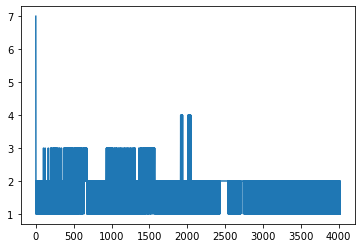

In [25]:
x = []
for y in f.read().split(','):
    print(y)
    if y.isdigit():
        x.append(float(y))

plt.plot(x)

In [4]:
'''
Conventions 

v = wavenumber[cm^-1] --- number if waves per cm. v = f/c
tau = transmittance --- ratio of transmitted radiance to incident radiance
epsilon = emissivity --- ratio of emitted radiance at v to the radiance emitted by the black body at the same temperature
alpha = absorptivity --- fraction of incident radiance at v that is absorbed
g = line shape
f = voigt profile
S = line intesity
alpha_doppler =
alpha_lorentz = 
v_center = 
E_l = 
T_0 = 296K
P_0 = 1atm

'''

'''
Parameters

v = give a list of values to calculate(spectral range)

'''

'\nConventions \n\nv = wavenumber[cm^-1] --- number if waves per cm. v = f/c\ntau = transmittance --- ratio of transmitted radiance to incident radiance\nepsilon = emissivity --- ratio of emitted radiance at v to the radiance emitted by the black body at the same temperature\nalpha = absorptivity --- fraction of incident radiance at v that is absorbed\n\n'

In [9]:
def wavenumber_center(pressure):
    P_0 = 1 #[atm] 
    pressureRatio = pressure/P_0
    #delta = 
    #v_0 =
    v_center = v_0 + delta*pressureRatio
    return v_center

def doppler_broadening(temperature):
    '''
    For pressures less than 0.1 atm, altitudes below 16 km
    '''
    T = temperature
    v_center = wavenumber_center(pressure) 
    #m = 
    sqrt = np.sqrt(2*spc.k*T/(m*spc.c**2))
    alpha_doppler = v_center*sqrt
    return alpha_doppler
    
def lorentz_broadening(pressure, temperature):
    P, T = pressure, temperature
    P_0 = 1 #[atm] unsure
    T_0 = 296 #[K]
    #alphaLorentz_a = 
    #alphaLorentz_s = 
    #q = 
    #gamma = 
    pressureRatio = P/P_0
    tempRatio = T_0/T
    alpha_lorentz = ((1-q)*alphaLorentz_a+q*alphaLorentz_s)*pressureRatio*tempRatio**gamma
    return alpha_lorentz

def integral_func(t, a, b):
    val = np.exp(-t**2)/((a - t)**2 + b**2)
    return val
    
def voigt_profile():
    alpha_doppler = doppler_broadening(pressure, temperature)
    alpha_lorentz = lorentz_broadening(temperature)
    #v = 
    v_center = wavenumber_center(pressure)  
    a = (v - v_center)/alpha_doppler
    b = alpha_lorentz/alpha_doppler
    integral = quad(integral_func, -np.inf, np.inf, )
    f = b*integral /(alpha_doppler*np.sqrt(np.pi)*np.pi)
    return f

def line_shape():
    #v =
    v_center = wavenumber_center(pressure)  
    f = voigt_profile()
    tanh = np.tanh(spc.h*spc.c*v/(2*spc.k*T))
    tanh_center = np.tanh(spc.h*spc.c * v_center/(2*spc.k*T))
    g = v * tanh * f/(v_center*tanh_center)
    return g

def line_shape(pressure):
    if pressure > 0.1:
        alpha = lorentz_broadening(pressure, temperature)
        a = ((v - v_c)/alpha)**2
        f = 1/(np.pi*alpha*(1+a))
        return f
    else:
        alpha = doppler_broadening(temperature)
        sigma = alpha*2/2.355
        a = ((v - v_c)/4*sigma)**2
        f = np.exp(-a)/(sigma*np.sqrt(2*np.pi))
        return f
    
def line_intensity(temperature):
    T = temperature
    v_center = wavenumber_center(pressure)
    #S_0, T_0 = ,296
    #Q_v, Q_r = 
    #Q_v0, Q_r0 =
    #E_l = 
    exp_lower = np.exp(spc.h*spc.c*E_l/(spc.k*T))
    exp_lower0 = np.exp(spc.h*spc.c*E_l/(spc.k*T_0))
    exp_center = np.exp(spc.h*spc.c*v_center/(spc.k*T))
    exp_center0 = np.exp(spc.h*spc.c*v_center/(spc.k*T))
    S = S_0*Q_v0*Q_r0*exp_lower*exp_center/(Q_v*Q_r*exp_lower0*exp_center0)
    return S
    
def transmittance(pressure, temperature):
    P = pressure
    T = temperature
    #x = 
    #q = 
    g = line_shape()
    S = line_intensity(temperature)
    numerator = -q*P*x*S*g
    denominator = spc.Boltzmann * T
    tau = np.exp(numerator/denominator)
    return tau